## 1. Perkenalan

====================================================

Nama : Panji Putra Rianto  

Link Huggingface : https://huggingface.co/spaces/panjiputra-r/BrainTumorDetection

Program ini dibuat untuk melakukan prediksi apakah seseorang memiliki tumor pada otak atau tidak berdasarkan foto MRI otak. Untuk melakukan prediksi, akan digunakan Computer Vision dengan model sequential dan akan dilakukan improvement terhadap model yang dibuat.

====================================================

## 2. Import Libraries

In [1]:
# Melakukan import libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 3. Data Loading

In [2]:
# loading dataset
os.listdir('C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7-panjiputra-r\Brain_tumor_dataset')

['Brain_tumor', 'Healthy']

Untuk dataset yang akan dilakukan analisa adalah data hasil scan MRI brain tumor. Directory pada dataset terbagi menjadi dua yaitu 'Brain_tumor' dan 'Healthy'

In [83]:
# membuat variabel untuk dataset
main_path=('C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7-panjiputra-r\Brain_tumor_dataset')

In [84]:
# membuat variabel berdasarkan data
brain_tumor_dir = os.path.join(main_path, 'Brain_tumor')
healthy_dir = os.path.join(main_path, 'Healthy')
print(brain_tumor_dir)

C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7-panjiputra-r\Brain_tumor_dataset\Brain_tumor


In [85]:
# menghitung jumlah data
num_tumor= len(os.listdir(os.path.join(brain_tumor_dir)))
num_healthy= len(os.listdir(os.path.join(healthy_dir)))
print(f'jumlah tumor= {num_tumor}')
print(f'jumlah normal= {num_healthy}')

jumlah tumor= 2513
jumlah normal= 2087


Dari hasil diatas terlihat bahwa terdapat data pada brain tumor sebanyak 2513. Sedangkan, untuk data brain yang normal atau tidak memiliki tumor sejumlah 2087. Bisa dikatakan walaupun terdapat perbedaan jumlah data tetapi masih dalam kategori balance.

In [86]:
# Mencari semua file gambar yang berada pada masing-masing folder
brain_tumor = glob.glob('C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7-panjiputra-r\Brain_tumor_dataset\Brain_tumor\*')
healthy = glob.glob('C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7-panjiputra-r\Brain_tumor_dataset\Healthy\*')

In [87]:
# Membuat dataframe dari data gambar
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('\\')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

df = create_dataframe(brain_tumor + healthy)
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

In [88]:
# Meload dataframe
print(df.shape)
df

(4600, 2)


,images,label
0,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Brain_tumor
1,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Brain_tumor
2,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Brain_tumor
3,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Brain_tumor
4,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Healthy
...,...,...
4595,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Healthy
4596,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Healthy
4597,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Brain_tumor
4598,C:\Panji\Hacktiv8\FASE_2\GC7\p2-ftds012-hck-g7...,Healthy


In [89]:
# Melakukan split train test
train_df, test_df = train_test_split(df, train_size=0.8,
                                    random_state=1,
                                    stratify = df['label'])

train_df, val_df = train_test_split(df, train_size=0.7,
                                    random_state=1,
                                    stratify = df['label'])
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(3220, 2)
(920, 2)
(1380, 2)


## 4. Exploratory Data Analysis (EDA)

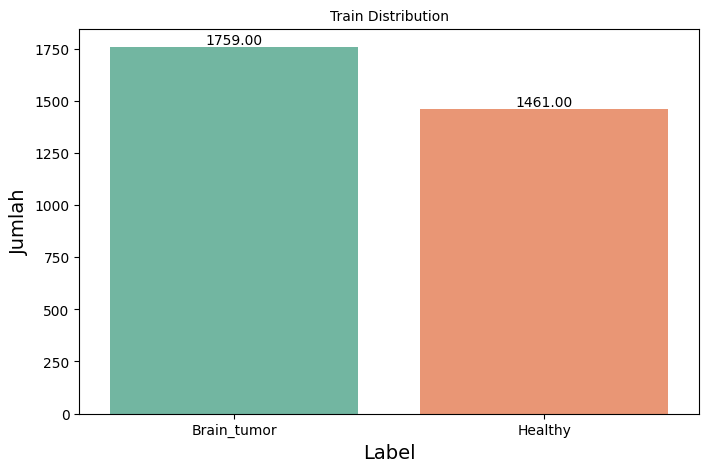

In [90]:
# Membuat visualisasi barchart
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of
    plt.title(f"{label} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

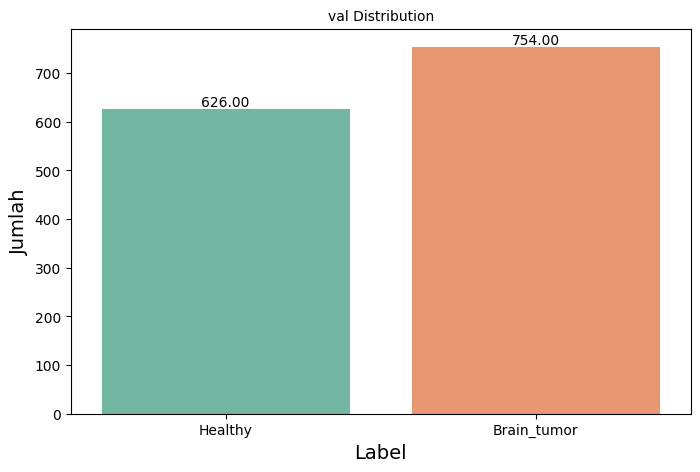

In [91]:
# visualisasi data val
visualize_data(val_df, 'val')

Dari hasil visualisasi diatas, terlihat bahwa distribusi data Train dan val sudah seimbang dengan Brain_tumor memiliki sedikit lebih banyak distribusi dibanding kan Healthy

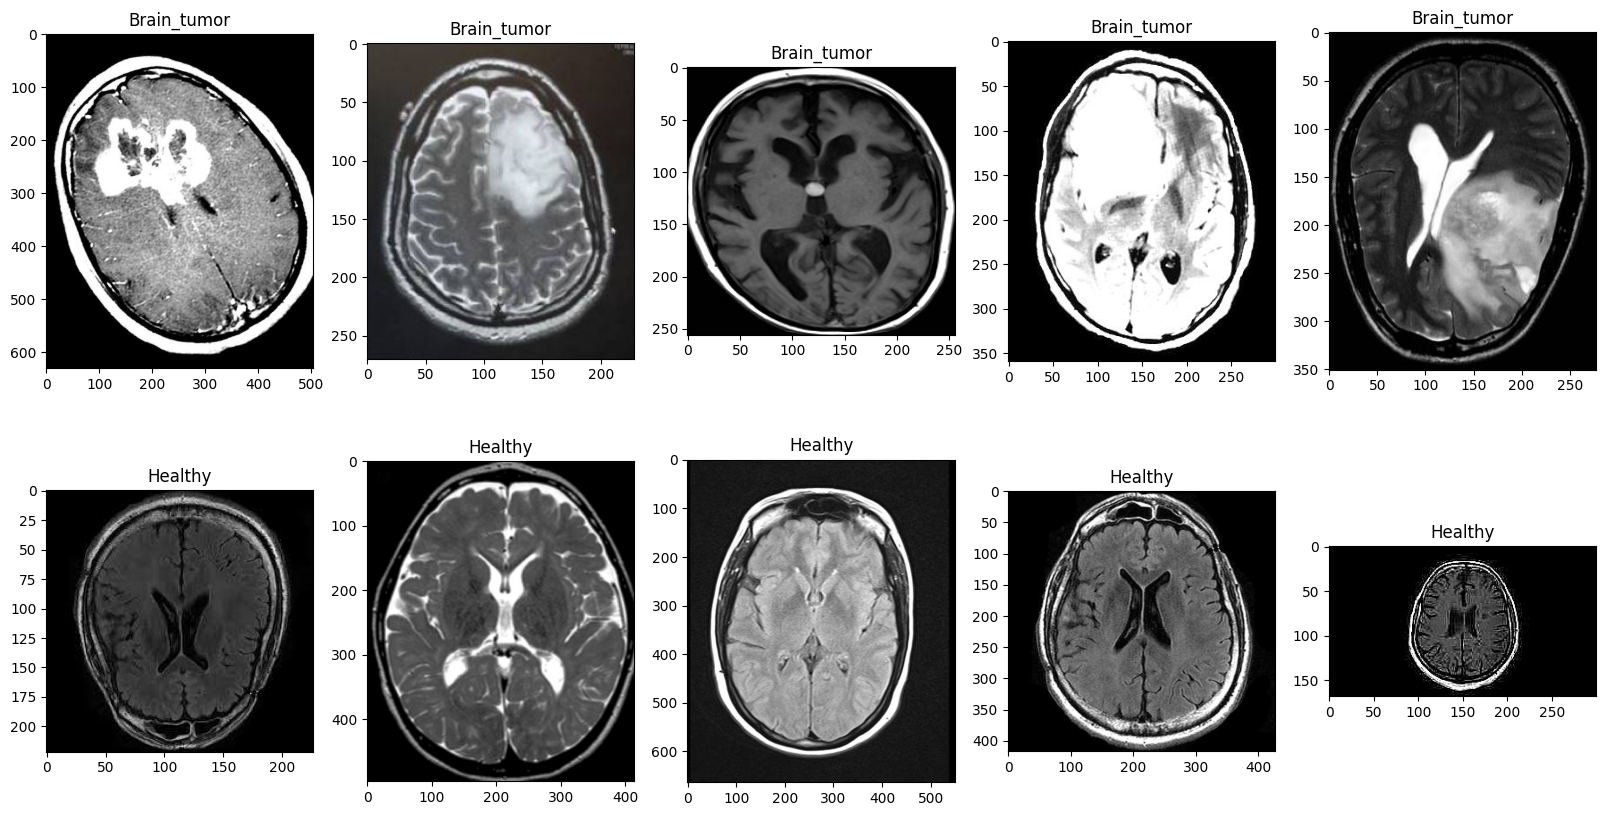

In [92]:
# Get few samples for both the classes
brain_tumor_samples = (train_df[train_df['label']=="Brain_tumor"]['images'].iloc[:5]).tolist()
healthy_samples = (train_df[train_df['label']=='Healthy']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('\\')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(brain_tumor_samples + healthy_samples)

Dari visualisasi diatas terlihat gambar dari data berdasarkan kelasnya yaitu Brain_tumor dan Healthy. Bisa dilihat juga pada gambar untuk perbedaan yang bisa dilihat sekilas antara gambar Brain_tumor dengan Healthy adalah pada Brain_tumor terdapat bercak putih yang terdapat pada otak, kemungkinan besar bercak putih tersebut adalah tumor pada otak. Berbeda dengan Healthy dimana tidak terdapat becak putih pada otaknya.

## 5. Feature Engineering

### Data Augmentation

In [93]:
img_height= 224
img_width= 224
SEED = 42
BATCH =32

In [94]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [95]:
# generate training, validation, dan test dari dataframe.
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 3220 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [96]:
ds_train.class_indices

{'Brain_tumor': 0, 'Healthy': 1}

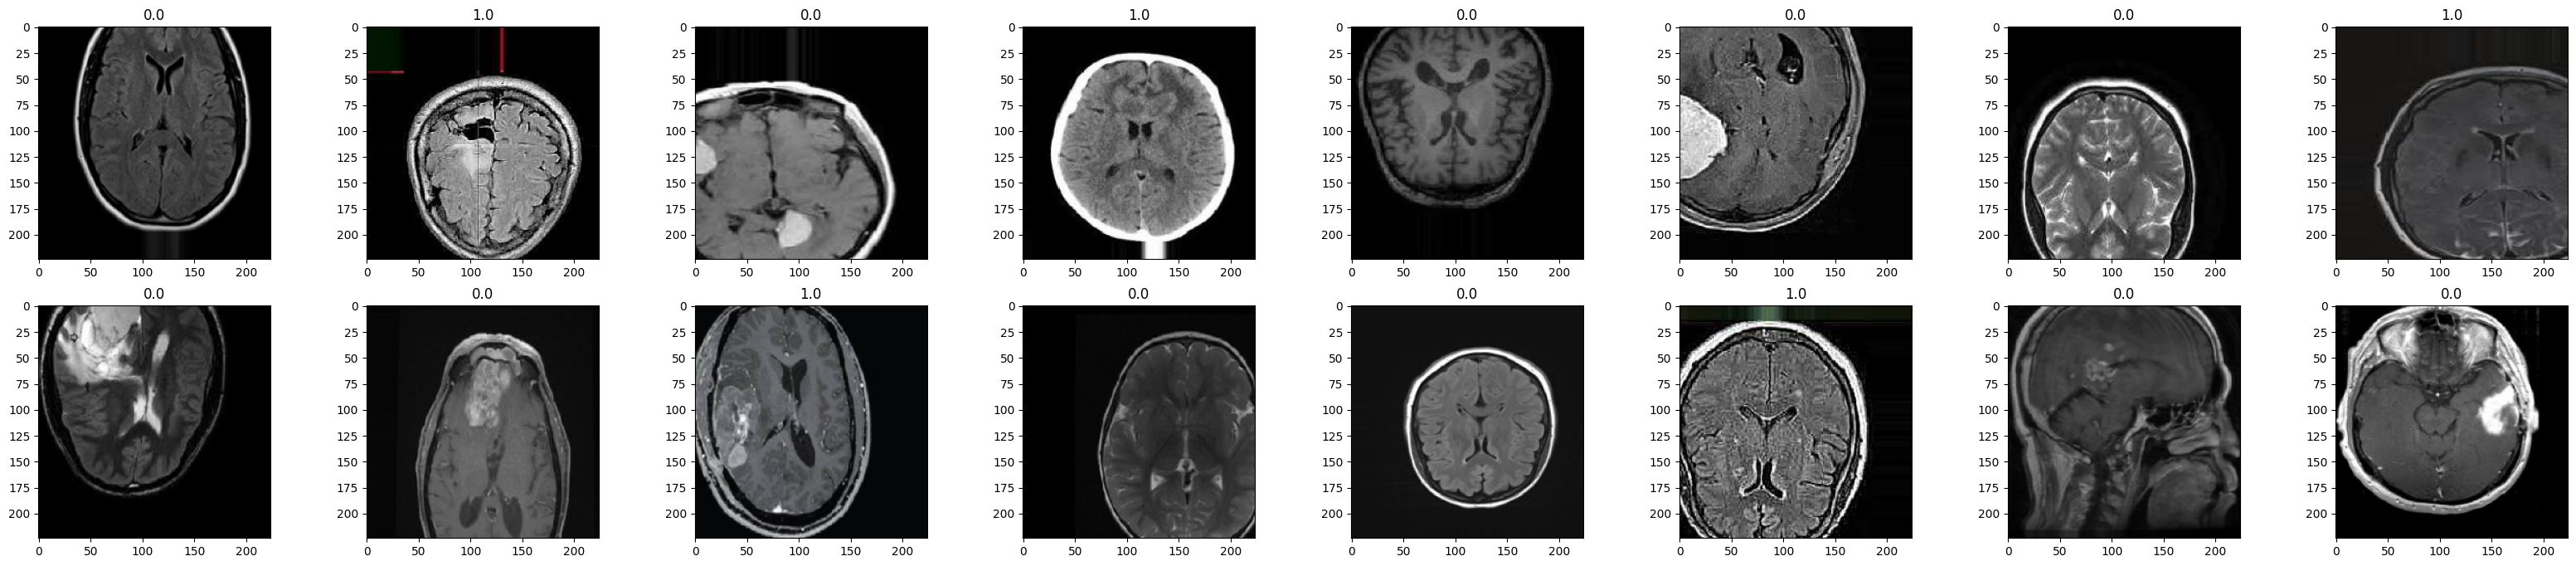

In [97]:
# Memvisualisasikan gambar
fig,ax = plt.subplots(nrows=2,ncols=8,figsize=(40,8))
n = 0
idx = np.random.randint(len(ds_train.next()[0]), size=16)
for i in range(2):
  for j in range(8):
    img = ds_train.next()[0][idx[n]]
    ax[i][j].imshow(img)
    ax[i][j].set_title(ds_train.next()[1][idx[n]])
    n+=1

Dari hasil visualisasi dapat terlihat gambar yang sudah dilakukan data augmentation.

## 6.  ANN Training

### Membuat Model Dengan Sequential

In [98]:
# Membuat callback
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 5),
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
    #ReduceLRonPlateau
]

In [99]:
inputs= [img_height,img_width,3]

#arsitektur model sequential
model_adam= Sequential()

#Layer Conv 1
model_adam.add(Conv2D(filters=16, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_adam.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       ))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 3
model_adam.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

model_adam.add(Flatten())
model_adam.add(Dense(units=128, activation='relu'))
model_adam.add(Dense(units=1,activation='sigmoid'))

In [100]:
model_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

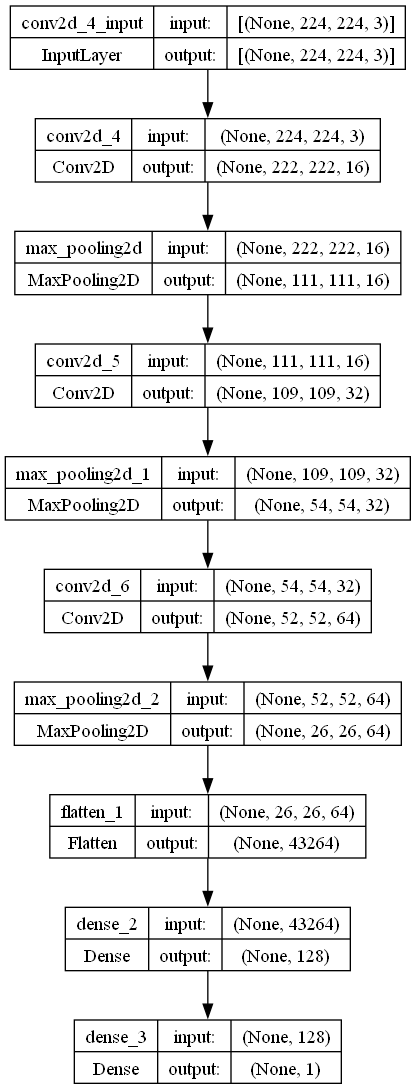

In [101]:
tf.keras.utils.plot_model(model_adam, show_shapes=True)

Layer pertama CNN adalah input layer, yang mengambil gambar sebagai input. Gambar tersebut kemudian dilewatkan melalui serangkaian convolutional layers, yang mengekstrak fitur dari gambar. Fitur-fitur ini kemudian dikumpulkan (pool), sehingga mengurangi dimensi data. Fitur-fitur yang dikumpulkan kemudian dilewatkan melalui serangkaian layer yang terhubung, yang digunakan untuk membuat classification decision.

In [102]:
model_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['accuracy'])

In [103]:
history= model_adam.fit(ds_train, batch_size= BATCH,
                           epochs= 21, validation_data= ds_val,
                           callbacks= callbacks1)

Epoch 1/21
101/101 [==============================] - 37s 361ms/step - loss: 0.6840 - accuracy: 0.5649 - val_loss: 0.5985 - val_accuracy: 0.6797
Epoch 2/21
101/101 [==============================] - 34s 334ms/step - loss: 0.6142 - accuracy: 0.6677 - val_loss: 0.6019 - val_accuracy: 0.6667
Epoch 3/21
101/101 [==============================] - 35s 344ms/step - loss: 0.5845 - accuracy: 0.6873 - val_loss: 0.5282 - val_accuracy: 0.7833
Epoch 4/21
101/101 [==============================] - 33s 326ms/step - loss: 0.5614 - accuracy: 0.7186 - val_loss: 0.4980 - val_accuracy: 0.7797
Epoch 5/21
101/101 [==============================] - 33s 324ms/step - loss: 0.5548 - accuracy: 0.7152 - val_loss: 0.5625 - val_accuracy: 0.7109
Epoch 6/21
101/101 [==============================] - 33s 329ms/step - loss: 0.5528 - accuracy: 0.7242 - val_loss: 0.4973 - val_accuracy: 0.7507
Epoch 7/21
101/101 [==============================] - 42s 418ms/step - loss: 0.5287 - accuracy: 0.7447 - val_loss: 0.4853 - val_ac

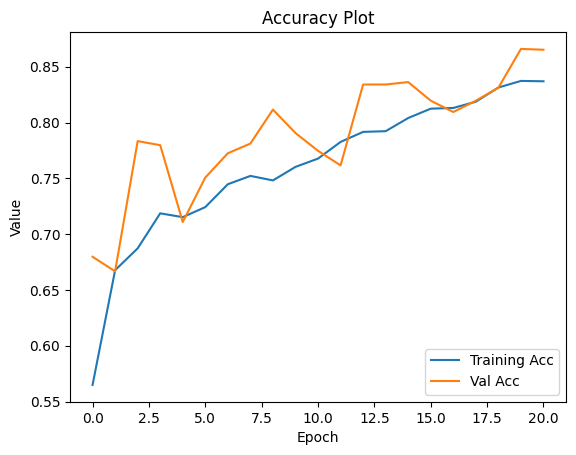

In [104]:
# Membuat visualisasi untuk Accuracy Plot
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Plot menunjukkan dua garis, satu untuk seberapa baik model belajar dari data train (garis biru) dan satu untuk seberapa baik ia dapat menerapkan apa yang telah dipelajarinya ke data baru (garis oranye). Kedua garis tersebut naik, yang berarti model semakin baik dari waktu ke waktu. Garis biru naik dengan cukup lancar, yang memberi tahu kita bahwa model secara stabil menjadi lebih baik dalam tugasnya dengan data yang ia latih.

Garis oranye, yang menunjukkan performa model pada data baru, juga naik namun dengan beberapa naik turun. Secara keseluruhan, performanya meningkat, yang merupakan tanda baik bahwa model belajar untuk generalisasi dan bukan hanya menghafal data train. Karena garis oranye tidak turun sementara garis biru naik, kita dapat mengatakan bahwa model tidak mengalami overfitting, atau dengan kata lain, tidak semakin buruk dalam menangani data baru. Pada akhir plot, garis oranye bahkan sedikit lebih tinggi dari garis biru, yang merupakan hasil yang sangat bagus karena hal itu berarti model sedikit lebih baik dalam menangani data baru daripada data yang ia latih.




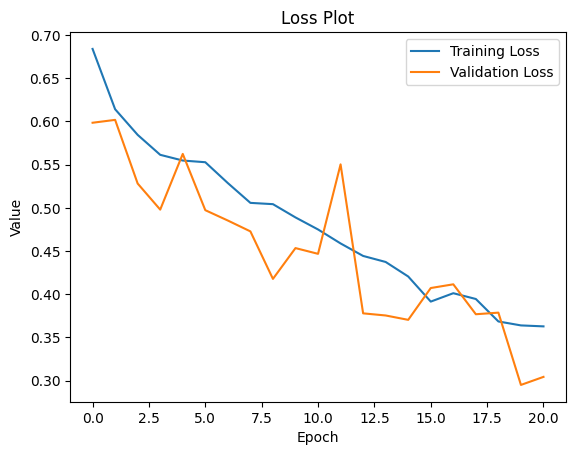

In [105]:
# Membuat visualisasi untuk Training dan Val Loss Plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Baik garis biru (training loss) maupun garis oranye (validation loss) menurun dari waktu ke waktu, yang berarti model semakin baik dalam tugasnya dengan setiap epoch. Tidak ada tanda overfitting karena kedua garis tetap berdekatan dan berakhir dekat satu sama lain.

In [106]:
test_results = model_adam.evaluate(df_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.2819
Test Accuracy : 0.8674


Akurasi tes adalah 86,74%. Artinya, model tersebut memprediksi dengan tepat hasil sebesar 86,74% pada kumpulan data pengujian, yang merupakan tingkat akurasi yang baik.
Test loss adalah 0.2819 yang relatif rendah. Hal ini menunjukkan bahwa rata-rata prediksi model cukup mendekati nilai sebenarnya pada data uji. Namun, akan dilakukan improvement terhadap model dengan harapan model bisa menjadi lebih baik lagi.

 

## 7. ANN Improvement

In [107]:
# callback2
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 3),
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True)
]

Untuk melakukan improvement pada model, akan digunakan transfer learning.

In [108]:
tf.keras.backend.clear_session()

# Melakukan load pre-trained Xception model
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=inputs, pooling='avg')

# Freeze layer
pretrained_model.trainable = False

# Membuat model baru
model_transfer = Sequential()
model_transfer.add(pretrained_model)
model_transfer.add(Flatten())
model_transfer.add(Dense(128, activation='relu'))
model_transfer.add(Dropout(0.5))
model_transfer.add(Dense(1, activation='sigmoid'))

# Print model summary
model_transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21123881 (80.58 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


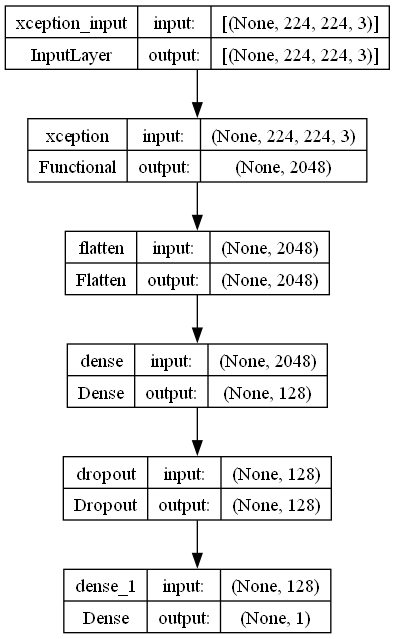

In [121]:
tf.keras.utils.plot_model(model_transfer, show_shapes=True)

Layer pertama CNN adalah input layer untuk gambar berukuran 224x224 pixels dengan 3 color channels. Pada transfer learning ini akan memanfaatkan model Xception, sebuah convolutional neural network untuk mengekstrak representasi fitur sebanyak 2048 dari input images. Fitur-fitur ini kemudian di-flatten menjadi vektor satu dimensi dan dilewatkan melalui dense layer untuk condense informasi ke 128. Untuk mengurangi overfitting, layer dropout digunakan. Terakhir, output layernya single value untuk classification.

In [109]:
model_transfer.compile(optimizer='adamax', loss='binary_crossentropy', metrics= ['accuracy'])

In [110]:
history_2= model_transfer.fit(ds_train, batch_size= BATCH,
                           epochs= 21, validation_data= ds_val,
                           callbacks= callbacks2)

Epoch 1/21
101/101 [==============================] - 114s 1s/step - loss: 0.4184 - accuracy: 0.8084 - val_loss: 0.3012 - val_accuracy: 0.8884
Epoch 2/21
101/101 [==============================] - 112s 1s/step - loss: 0.3124 - accuracy: 0.8755 - val_loss: 0.2628 - val_accuracy: 0.9051
Epoch 3/21
101/101 [==============================] - 111s 1s/step - loss: 0.2647 - accuracy: 0.9056 - val_loss: 0.2320 - val_accuracy: 0.9138
Epoch 4/21
101/101 [==============================] - 113s 1s/step - loss: 0.2584 - accuracy: 0.8950 - val_loss: 0.2166 - val_accuracy: 0.9217
Epoch 5/21
101/101 [==============================] - 114s 1s/step - loss: 0.2374 - accuracy: 0.9078 - val_loss: 0.2120 - val_accuracy: 0.9210
Epoch 6/21
101/101 [==============================] - 113s 1s/step - loss: 0.2318 - accuracy: 0.9124 - val_loss: 0.1987 - val_accuracy: 0.9174
Epoch 7/21
101/101 [==============================] - 113s 1s/step - loss: 0.2030 - accuracy: 0.9239 - val_loss: 0.1859 - val_accuracy: 0.9254

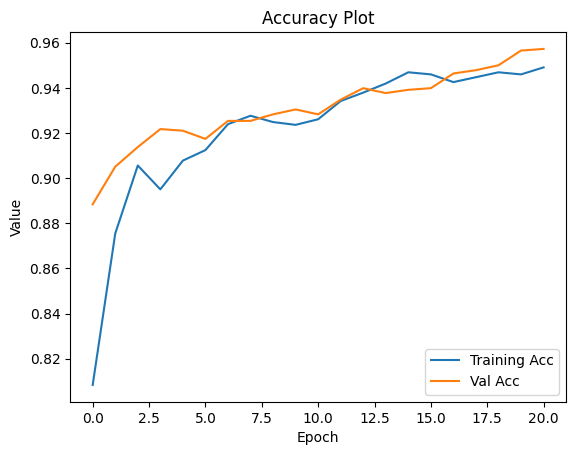

In [113]:
# Membuat visualisasi untuk Accuracy Plot
plt.plot(history_2.history['accuracy'], label='Training Acc')
plt.plot(history_2.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Akurasi train dan validasi kini berada di atas 88%, yang merupakan angka yang cukup tinggi. Hal ini menunjukkan efektivitas yang signifikan dalam prediksi model. Model improvement telah menghasilkan akurasi yang tinggi pada set train dan validasi, yang menunjukkan bahwa model tersebut performanya konsisten di kedua set, yang merupakan pertanda bahwa modelnya merupakan model yang baik.

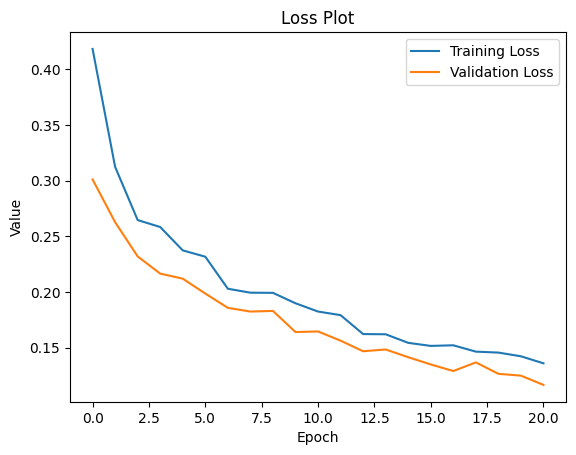

In [115]:
# Membuat visualisasi untuk Training dan Val Loss Plot
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

Training loss (garis biru) menurun tajam di awal, menunjukkan bahwa model dengan cepat belajar dari data pelatihan. Singkatnya, setelah improvement, model menunjukkan pola pembelajaran yang konsisten dan stabil dengan tingkat kesalahan yang rendah pada set train dan validasi, yang menunjukkan model berperforma baik.

In [116]:
test_results2 = model_transfer.evaluate(df_test, verbose=0)
print(f'Test Loss     : {test_results2[0]:.4f}')
print(f'Test Accuracy : {test_results2[1]:.4f}')

Test Loss     : 0.1042
Test Accuracy : 0.9620


Test loss sebesar 0,1042 cukup rendah, yang menunjukkan bahwa rata-rata prediksi model sangat mendekati nilai sebenarnya. Hal ini menunjukkan tingkat presisi yang tinggi dalam performa model. Akurasi sebesar 96,20% menunjukan model memprediksi dengan tepat hasil lebih dari 96 kali dari 100 pada data baru yang tidak dilatih. Tingkat akurasi ini menunjukkan bahwa model tersebut sangat efektif dalam menjalankan tugasnya.

## 8. Model Evaluation

29/29 [==============================] - 22s 767ms/step
Classification Report:
              precision    recall  f1-score   support

 Brain_tumor       0.95      0.98      0.96       503
     Healthy       0.97      0.94      0.95       417

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



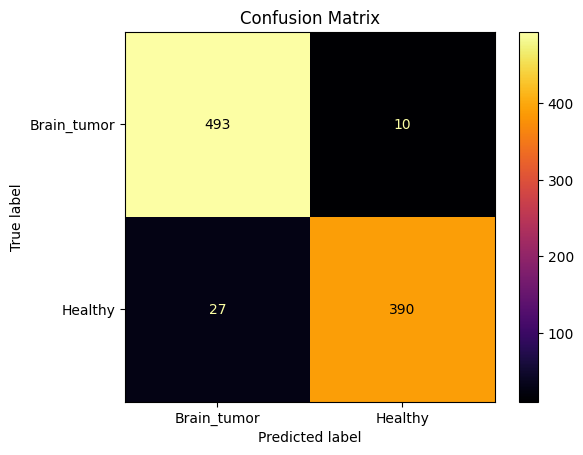

In [120]:
# Membuat classification report dan confusion matrix
y_pred_test = model_transfer.predict(df_test)

y_pred_test = (y_pred_test > 0.6).astype(int)

class_report = classification_report(df_test.labels, y_pred_test, labels=np.arange(2),
                                        target_names=list(df_test.class_indices.keys()))

print("Classification Report:")
print(class_report)

confusionmatrix = confusion_matrix(df_test.labels, y_pred_test)

disp_matrix = ConfusionMatrixDisplay(confusionmatrix, display_labels=list(df_test.class_indices.keys()))
disp_matrix.plot(cmap='inferno', values_format='d') 
plt.title('Confusion Matrix')
plt.title('Confusion Matrix')
plt.show()



Model ini menunjukkan kinerja yang kuat di berbagai metrik, termasuk precision, recall, F1-score, dan akurasi keseluruhan. Dengan nilai precision sebesar 0.95 untuk Brain_tumor dan 0.97 untuk Healthy, model ini menunjukkan akurasi tinggi dalam memprediksi kedua kelas. Selain itu, dengan mencapai skor recall sebesar 0.98 untuk Brain_tumor dan 0.94 untuk Healthy, model tersebut secara efektif mengidentifikasi sebagian besar kasus aktual untuk kedua kelas. 

Confusion matrix menunjukkan kemampuan model yang kuat dalam mengidentifikasi kasus Brain_tumor dan Healthy. Model ini mencapai akurasi tinggi baik dalam True Positives (493 kasus yang teridentifikasi dengan benar sebagai "Brain_tumor") maupun True Negatives (390 kasus yang teridentifikasi dengan benar sebagai "Healthy"). Jumlah False Positives (10 kasus) yang rendah menunjukkan bahwa model jarang salah mengklasifikasikan kasus sehat sebagai kasus tumor. Namun, ada 27 False Negatives, menunjukkan kasus-kasus di mana model gagal mendeteksi Brain_tumor, yang merupakan kekhawatiran penting dalam diagnostik medis. Secara keseluruhan, model menunjukkan kinerja yang sangat baik.


## 9. Model Saving

In [ ]:
# menyimpan model yang dibuat
model_transfer.save('model_transfer.h5')

## 10. Model Inference

Model inference terdapat pada P2G7_panji_putra_inference.ipynb

## Conclusion

Dengan menggunakan model Convolutional Neural Network (CNN) dan teknik Sequential, saya berhasil mengembangkan sebuah model yang mampu memprediksi keberadaan tumor otak berdasarkan foto scan MRI dengan akurasi sebesar 86% dan nilai loss sebesar 28%. Namun, saya tidak berhenti di situ, karena saya melakukan perbaikan lebih lanjut dengan menerapkan teknik transfer learning menggunakan model Xception. Hasilnya menunjukkan peningkatan yang signifikan, dengan akurasi model meningkat hingga 96% dan nilai loss yang berkurang drastis menjadi hanya 10%.  

Ketika melihat confusion matrix, model menunjukkan kemampuan yang kuat dalam mengklasifikasikan kasus Brain_tumor dan Healthy. Dengan jumlah True Positives (493 kasus) dan True Negatives (390 kasus) yang tinggi, model ini mampu mengidentifikasi dengan akurat baik kasus tumor maupun sehat. Jumlah False Positives (10 kasus) rendah, yang menunjukkan bahwa model jarang salah mengklasifikasikan kasus sehat sebagai kasus tumor, namun perlu diperhatikan bahwa terdapat 27 False Negatives, menandakan adanya kasus di mana model gagal mendeteksi keberadaan tumor, yang merupakan kekhawatiran penting dalam konteks diagnostik medis.


Dari hasil ini, dapat disimpulkan bahwa model yang telah dikembangkan menunjukkan kinerja yang sangat baik dalam memprediksi keberadaan tumor otak berdasarkan gambaran scan MRI. Dengan akurasi yang tinggi, nilai precision, recall, dan F1-score yang memuaskan, serta kemampuan model dalam mengidentifikasi kasus-kasus sebenarnya dengan tepat, saya percaya bahwa model ini siap untuk diadopsi oleh perusahaan atau institusi medis untuk mendukung diagnosis dan perencanaan perawatan pasien dengan lebih efektif. 